In [1]:
import torch
import timm
import pyvips
import pandas as pd
import os
import tifffile as tifi
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import h5py
import pandas as pd
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [2]:
"""pyvipsと呼ばれる画像を高速かつ少メモリで処理するライブラリを使って
画像を読み込みそれをnumpyにして返す関数"""

def vips2numpy(vi):
    
    # map vips formats to np dtypes
    format_to_dtype = {
        'uchar': np.uint8,       'char': np.int8,
        'ushort': np.uint16,     'short': np.int16,
        'uint': np.uint32,       'int': np.int32,
        'float': np.float32,     'double': np.float64,
        'complex': np.complex64, 'dpcomplex': np.complex128,
    }
    
    # Return newly written np.ndarray
    return np.ndarray(buffer=vi.write_to_memory(),
                      dtype=format_to_dtype[vi.format],
                      shape=[vi.height, vi.width, vi.bands])


""""pyvipsを使って画像を読み込みそれをnumpyにして返す関数"""
def pyvips_open_downsampled_slide(img_path, downsample_by=8, as_numpy=True, resize_to=(224,224)):
    """
    
    Helper function to convert WSI into smaller downscaled version using pyvips.
    
    Timing details for MAYO CLINIC STRIP AI dataset:
        SMALLEST IMAGE BY AREA (4417, 5314)
            * Function takes ~1 seconds to run
        MEDIAN IMAGE BY AREA   (17573, 38743)(~30X LARGER THAN SMALLEST IMAGE)
            * Function takes ~30 seconds to run
        LARGEST IMAGE BY AREA  (48282, 101406)(~208X LARGER THAN SMALLEST IMAGE)(~7X LARGER THAN MEDIAN IMAGE)
            * Function takes ~405 seconds to run
    
    Args:
        img_path (str): Path to .tif file to be downsampled
        downsample_by (int): How many times smaller should resultant 
            image be. i.e. image_size*(1/downsample_by) = new_size
            -1 will yield maximum downsample above resized image shape
        as_numpy (bool, optional): Whether to return image as numpy array (default)
           or leave as PIL.Image object for further manipulation
        resize_to (tuple of ints, optional): What to resize the downsampled image to
    
    Returns:
        Downsampled image as a numpy array of type uint8 with only 3 channels
    """
    
    # Open the image with PIL
    tmp_img = pyvips.Image.new_from_file(img_path)    
    
    #print("\n... APPROXIMATE TIME TO LOAD IMAGE IS AT MOST APPROXIMATELY: " \
          #f"{int((405/(48282*101406))*(tmp_img.width*tmp_img.height))} SECONDS ...\n")
    
    # if -1 than we downsample by whatever results in the image having dimensions as
    # close to 512x512 as possible so the image can be resized after
    
    if downsample_by==-1:
        _epsilon = 1e-3
        downsample_by=min(tmp_img.width, tmp_img.height)/resize_to[0]-_epsilon
    
    # Resize the image
    tmp_img = tmp_img.resize(1/downsample_by)
    tmp_img = vips2numpy(tmp_img) if as_numpy else tmp_img
    tmp_img = cv2.resize(tmp_img, resize_to) if resize_to is not None else tmp_img
    
    return tmp_img

In [3]:
import os
from collections import Counter
import pandas as pd

# 現在のスクリプトのディレクトリを取得
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))

# 相対パスを組み立てる
relative_path = os.path.join(current_dir, "convnext/dataset.csv")

# ファイルを読み込む
Counter(pd.read_csv(relative_path).label.values.tolist())

Counter({'sml_bird': 300, 'mid_bird': 300, 'noo_bird': 300, 'big_bird': 300})

In [4]:
train_df = pd.read_csv(relative_path)
train_df          

,filename,label
0,c00288,sml_bird
1,c00200,sml_bird
2,c00286,sml_bird
3,c00237,sml_bird
4,c00086,sml_bird
...,...,...
1195,a00120,big_bird
1196,a00278,big_bird
1197,a00053,big_bird
1198,a00242,big_bird


In [5]:
from PIL import Image
train_path = current_dir +"/convnext/train/"

img = Image.open(train_path+"a00001.jpg")
print(img)
# x1 = img.size[0]
# x2 = img.size[1]
# sc = x2/x1



# factor = 1/10
# resized_img = img.resize((int(x1*factor), int(sc*x1*factor)))

# print(resized_img.size)
# resized_img.rotate(90, expand=True)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7FA4468DF9A0>


In [6]:
import gc
gc.enable()

labels = {"big_bird":0, "mid_bird":1,"noo_bird":2,"sml_bird":3}

converted_train_path = current_dir+"/convnext/save_npy/"
saved_converted_path = current_dir+"/convnext/save_img/"
train_img_paths = []
train_y = []
# test_path="/home/waki-lab/デスクトップ/chiba/chiba2023_kouki/画像系/画像/testセット(テスト)/"
for n, (i,j) in enumerate(zip(train_df['filename'].values, train_df['label'].values)):
    print(f"{n}/{len(train_df['label'].values)}", end="\r")
    if f"{i}.npy" not in os.listdir(saved_converted_path):
        img = pyvips_open_downsampled_slide(train_path+i+'.jpg', downsample_by=-1, as_numpy=True, resize_to=(224,224))
        np.save(f"{converted_train_path}{i}.npy", img)
        train_img_paths.append(converted_train_path + i + '.npy')
        del img
        gc.collect()
                
    else:
        train_img_paths.append(saved_converted_path + i + '.jpg')
    train_y.append(labels[j])

print(train_img_paths)
c = list(zip(train_img_paths, train_y))
print(c)
random.shuffle(c)

train_img_paths, train_y = zip(*c)
train_y = list(train_y)
train_img_paths = list(train_img_paths)



['/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00288.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00200.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00286.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00237.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00086.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00162.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00047.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00003.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00256.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00185.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00105.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00232.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00157.npy'

In [7]:
print(train_img_paths)
print(train_y)

n_val = 300

val_y = []
val_img_paths = []

i = 0 # start
j = 0 # class 0 count
k = 0 # class 1 count
l = 0 # class 2 count
m = 0 # class 3 count


while len(val_y)!=n_val:
    if train_y[i] == 0 and j<int(n_val/2):
        j+=1
        val_y.append(train_y.pop(i))
        val_img_paths.append(train_img_paths.pop(0))
        i=0
        

    elif train_y[i] == 1 and k<n_val-int(n_val/2):
        k+=1
        val_y.append(train_y.pop(i))
        val_img_paths.append(train_img_paths.pop(0))
        i=0
    
    elif train_y[i] == 2 and l<n_val-int(n_val/2):
        l+=1
        val_y.append(train_y.pop(i))
        val_img_paths.append(train_img_paths.pop(0))
        i=0
    
    elif train_y[i] == 3 and m<n_val-int(n_val/2):
        m+=1
        val_y.append(train_y.pop(i))
        val_img_paths.append(train_img_paths.pop(0))
        i=0
        
    else:
        i+=1
        
Counter(val_y)

['/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00197.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/b00243.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/a00028.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/a00077.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/a00018.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/d00161.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/d00250.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/b00056.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/b00183.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/a00074.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/c00156.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/d00271.npy', '/home/waki-lab/Desktop/chiba/chiba2023_kouki/convnext/save_npy/d00116.npy'

Counter({3: 74, 1: 76, 0: 72, 2: 78})

In [8]:
class ImgDataset(Dataset):
    
    def __init__(self, x, y, dataset_type):
        self.x = x
        self.y = y
        self.transform_train = T.Compose([T.RandomHorizontalFlip(),
                                    T.RandomVerticalFlip(),
                                    T.RandomRotation(30),
                                    T.ToTensor(),
                                    T.ConvertImageDtype(torch.float32),
                                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
   
        self.transform_val = T.Compose([T.ToTensor(),
                                    T.ConvertImageDtype(torch.float32),
                                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
        self.dataset_type = dataset_type
        
#         if 'cache' not in os.listdir('./'):
#             h5_file = h5py.File('cache', 'w')
        
#         else:
#             h5_file = h5py.File('cache', 'a')
        
# #         if self.dataset_type not in h5_file:
# #             index_dataset = h5_file.create_dataset(dataset_type, shape=(len(x), 3, 224, 224), dtype=np.float32, fillvalue=0)
#         h5_file.close()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
#         h5_file = h5py.File('cache', 'a')
        
#         if f'{idx}_{self.dataset_type}' not in h5_file: # true if empty/not cached
#             img = Image.fromarray(cv2.resize(tifi.imread(self.x[idx]),(224, 224)))
#             if self.dataset_type == 'train':
#                 img = self.transform_train(img)
#             elif self.dataset_type == 'val':
#                 img = self.transform_val(img)
                
#             index_dataset = h5_file.create_dataset(f'{idx}_{self.dataset_type}', shape=(3, 224, 224), dtype=np.float32, data = img.numpy(), chunks=True)
            
#         else:
#             img = torch.FloatTensor(data[f'{idx}_{self.dataset_type}'])

        img = Image.fromarray(np.load(self.x[idx]))
        if self.dataset_type == 'train':
            img = self.transform_train(img)
        elif self.dataset_type == 'val':
            img = self.transform_val(img)
            
        label = torch.LongTensor([self.y[idx]])
#         h5_file.close()
        

        return img, label 
    
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
    
train_dataset = ImgDataset(train_img_paths, train_y, dataset_type = 'train')
validation_dataset = ImgDataset(val_img_paths, val_y, dataset_type = 'val')
validation_dataloader = DataLoader(validation_dataset, batch_size = 16, shuffle=False, worker_init_fn=seed_worker, generator=g)
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=False, worker_init_fn=seed_worker, generator=g)

In [9]:
class ConvNext(nn.Module):
    def __init__(self, n_classes, pretrained=True):

        super(ConvNext, self).__init__()

        self.model = timm.create_model("convnext_small_384_in22ft1k", pretrained=True)
        # if pretrained:
        #     self.model.load_state_dict(torch.load("../input/timm-convnext-xcit/convnext_small_384_in22ft1k.pth"))
        self.model.head.fc = nn.Linear(self.model.head.fc.in_features, n_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

epoch = 5
convnext_model = ConvNext(4, True)
loss_history = [[], []] #train, val
accuracy_history = [[], []] #train, val
acc_epoch_history = [[],[]]
loss_epoch_history = [[],[]]

optimizer = torch.optim.Adam(convnext_model.parameters(), lr=2e-04)
criterion = nn.CrossEntropyLoss()

/home/waki-lab/anaconda3/envs/wakilab/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_384_in22ft1k to current convnext_small.fb_in22k_ft_in1k_384.
  model = create_fn(


In [10]:
for batch in train_dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1])
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 1])
tensor([[0],
        [2],
        [0],
        [2],
        [3],
        [3],
        [1],
        [2],
        [3],
        [3],
        [3],
        [0],
        [3],
        [2],
        [2],
        [2]])


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df_train = pd.DataFrame()
df_value = pd.DataFrame()
print("使用デバイス：", device)

convnext_model.to(device)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
bestloss=None
# now=str(datetime.datetime.now())
epochnumber=0
epochnumbers={}

for e in range(epoch):

    convnext_model.train()
    print(f"====================== EPOCH {e+1} ======================")
    print("Training.....")
    for i, (data, target) in enumerate(train_dataloader):

        #print(data)
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = convnext_model(data)
        output_np = output.detach().cpu().numpy() # detachで勾配計算を切る
        df = pd.DataFrame(output_np) 
        df_train = df_train.append(df, ignore_index=True)
        loss = criterion(output, target.view(-1,))
        loss.backward()
        
        nn.utils.clip_grad_norm_(convnext_model.parameters(), 3)
        accuracy = (output.argmax(dim=1) == target).float().mean()
        
        loss_history[0].append(loss.item())
        accuracy_history[0].append(accuracy)
        
        optimizer.step()
        
        print(f"MINIBATCH {i+1}/{train_dataloader.__len__()} TRAIN ACC : {accuracy_history[0][-1]}  TRAIN LOSS : {loss_history[0][-1]}")
            

    print("Validation.....")
    convnext_model.eval()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(validation_dataloader):
            data, target = data.to(device), target.to(device)
            output = convnext_model(data)
            output_np = output.detach().cpu().numpy()
            df = pd.DataFrame(output_np) 
            df_value = df_value.append(df, ignore_index=True)
            loss = criterion(output, target.view(-1,))
            accuracy = (output.argmax(dim=1) == target).float().mean()
            loss_history[1].append(loss.item())
            accuracy_history[1].append(accuracy)
        
    acc_epoch_history[0].append(sum(accuracy_history[0][-1:-train_dataloader.__len__():-1])/train_dataloader.__len__())
    acc_epoch_history[1].append(sum(accuracy_history[1][-1:-validation_dataloader.__len__():-1])/validation_dataloader.__len__())
    
    loss_epoch_history[0].append(sum(loss_history[0][-1:-train_dataloader.__len__():-1])/train_dataloader.__len__())
    loss_epoch_history[1].append(sum(loss_history[1][-1:-validation_dataloader.__len__():-1])/validation_dataloader.__len__())
    
    print("====================================================")
    print(f"TRAIN ACC : {acc_epoch_history[0][-1]}  TRAIN LOSS : {loss_epoch_history[0][-1]}")
    print(f"VALL ACC : {acc_epoch_history[1][-1]}  VAL LOSS : {loss_epoch_history[1][-1]}")
    print("====================================================")
    train_loss.append(loss_epoch_history[0][-1])
    train_acc.append(acc_epoch_history[0][-1])
    val_loss.append(loss_epoch_history[1][-1])
    val_acc.append(acc_epoch_history[1][-1])
    
    # torch.save({
    #         'epoch': e,
    #         'model_state_dict': convnext_model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss_epoch_history[0][-1],
    #         'acc' : acc_epoch_history[0][-1]
    #         }, '/home/waki-lab/デスクトップ/chiba/chiba2023_kouki/画像系/save_pth/model_checkpoint.pth')
    
    torch.save(convnext_model.state_dict(), current_dir+'/convnext/save_pth/model_checkpoint.pth')

使用デバイス： cuda:0
====================== EPOCH 1 ======================
Training.....


/tmp/ipykernel_107325/1369528228.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df, ignore_index=True)


MINIBATCH 1/57 TRAIN ACC : 0.29296875  TRAIN LOSS : 1.3169684410095215
MINIBATCH 2/57 TRAIN ACC : 0.3203125  TRAIN LOSS : 1.4526315927505493
MINIBATCH 3/57 TRAIN ACC : 0.28515625  TRAIN LOSS : 1.029790997505188
MINIBATCH 4/57 TRAIN ACC : 0.28125  TRAIN LOSS : 0.8614705204963684
MINIBATCH 5/57 TRAIN ACC : 0.34375  TRAIN LOSS : 0.6695892810821533
MINIBATCH 6/57 TRAIN ACC : 0.3515625  TRAIN LOSS : 0.5523848533630371
MINIBATCH 7/57 TRAIN ACC : 0.27734375  TRAIN LOSS : 0.3630239963531494
MINIBATCH 8/57 TRAIN ACC : 0.3359375  TRAIN LOSS : 0.1554190218448639
MINIBATCH 9/57 TRAIN ACC : 0.26953125  TRAIN LOSS : 0.1831320822238922
MINIBATCH 10/57 TRAIN ACC : 0.265625  TRAIN LOSS : 0.10406509786844254
MINIBATCH 11/57 TRAIN ACC : 0.265625  TRAIN LOSS : 0.9415276050567627
MINIBATCH 12/57 TRAIN ACC : 0.265625  TRAIN LOSS : 0.06971869617700577
MINIBATCH 13/57 TRAIN ACC : 0.2890625  TRAIN LOSS : 0.39101117849349976
MINIBATCH 14/57 TRAIN ACC : 0.26171875  TRAIN LOSS : 0.3374318480491638
MINIBATCH 15/57

/tmp/ipykernel_107325/1369528228.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_value = df_value.append(df, ignore_index=True)


TRAIN ACC : 0.289336621761322  TRAIN LOSS : 0.194130967776577
VALL ACC : 0.28367143869400024  VAL LOSS : 0.0008507434793404842
====================== EPOCH 2 ======================
Training.....
MINIBATCH 1/57 TRAIN ACC : 0.3203125  TRAIN LOSS : 0.005904253572225571
MINIBATCH 2/57 TRAIN ACC : 0.3125  TRAIN LOSS : 0.3937724828720093
MINIBATCH 3/57 TRAIN ACC : 0.2578125  TRAIN LOSS : 0.0019749198108911514
MINIBATCH 4/57 TRAIN ACC : 0.296875  TRAIN LOSS : 0.004793296102434397
MINIBATCH 5/57 TRAIN ACC : 0.3203125  TRAIN LOSS : 0.003842171747237444
MINIBATCH 6/57 TRAIN ACC : 0.35546875  TRAIN LOSS : 0.20344901084899902
MINIBATCH 7/57 TRAIN ACC : 0.2734375  TRAIN LOSS : 0.012711535207927227
MINIBATCH 8/57 TRAIN ACC : 0.3359375  TRAIN LOSS : 0.022660020738840103
MINIBATCH 9/57 TRAIN ACC : 0.2734375  TRAIN LOSS : 0.04915984719991684
MINIBATCH 10/57 TRAIN ACC : 0.265625  TRAIN LOSS : 0.04386166110634804
MINIBATCH 11/57 TRAIN ACC : 0.265625  TRAIN LOSS : 0.27652648091316223
MINIBATCH 12/57 TRAIN

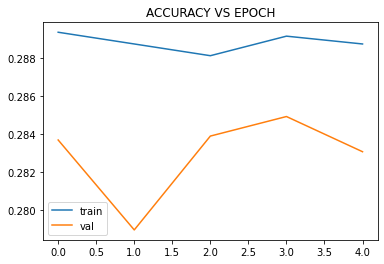

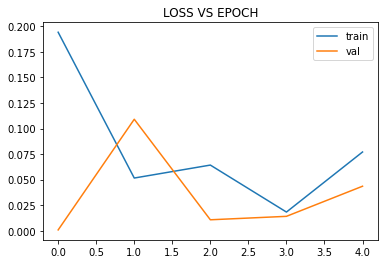

In [12]:
import torch
import matplotlib.pyplot as plt
acc_train = torch.tensor(acc_epoch_history[0])
acc_val = torch.tensor(acc_epoch_history[1])
loss_train = torch.tensor(loss_epoch_history[0])
loss_val = torch.tensor(loss_epoch_history[1])

plt.plot(acc_train.cpu(), label="train")
plt.plot(acc_val.cpu(), label="val")
plt.legend()
plt.title('ACCURACY VS EPOCH')
plt.show()

plt.plot(loss_train.cpu(), label="train")
plt.plot(loss_val.cpu(), label="val")
plt.legend()
plt.title('LOSS VS EPOCH')
plt.show()